<a href="https://colab.research.google.com/github/Otobi1/Online-Retail-Transactions/blob/master/Online_Retail_Transactions_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Installing lifetimes and jcopml quietly (without the install logs)

!pip install lifetimes --quiet # (https://pypi.org/project/Lifetimes/ ) provides some details on what this is used for, particularly for ecommerce, predicting CLV
!pip install jcopml --quiet # (https://pypi.org/project/jcopml/)

     |████████████████████████████████| 593kB 4.3MB/s 
     |████████████████████████████████| 102kB 4.4MB/s 


In [2]:
# Importing the necessary libraries 

import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from matplotlib.image import imread
import seaborn as sns
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics.pairwise import  cosine_similarity
import datetime as dt
from lifetimes.utils import summary_data_from_transaction_data
from jcopml.plot import plot_missing_value

%matplotlib inline
sns.set_context('notebook')
plt.style.use('fivethirtyeight')
from warnings import filterwarnings
filterwarnings('ignore')

print ('Libraries successfully imported!')

Libraries successfully imported!


In [3]:
# Downloading the dataset from the UCI Data Repo

!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00502/online_retail_II.xlsx

# Data is on two tabs in the spreadsheet

--2021-06-23 18:38:31--  https://archive.ics.uci.edu/ml/machine-learning-databases/00502/online_retail_II.xlsx
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45622278 (44M) [application/x-httpd-php]
Saving to: ‘online_retail_II.xlsx’

online_retail_II.xl 100%[===================>]  43.51M  15.2MB/s    in 2.9s    

2021-06-23 18:38:34 (15.2 MB/s) - ‘online_retail_II.xlsx’ saved [45622278/45622278]



In [4]:
# Reading the data from the first tab of the spreadsheet. 

df_09_10 = pd.read_excel('online_retail_II.xlsx', 'Year 2009-2010', index_col=None, na_values=['NA'])

# Making a copy of the original dataset from the first tab.

data_09_10 = df_09_10.copy()

In [5]:
# Exploring the first 5 observations.

data_09_10.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [6]:
# Checking the dimensions of the dataset in the first tab

data_09_10.shape

(525461, 8)

In [7]:
# Reading the data from the second tab of the spreadsheet

df_10_11 = pd.read_excel('online_retail_II.xlsx', 'Year 2010-2011', index_col=None, na_values=['NA'])

# Making a copy of the original dataset from the second tab

data_10_11 = df_10_11.copy()

In [8]:
# Checking the first 5 observations in the dataset from the second tab

data_10_11.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [9]:
# Exploring the dimensions of the dataset in the second tab

data_10_11.shape

(541910, 8)

In [10]:
# Merging the datasets from the two tabs into one single dataframe

# Placing both dataframes into a list

total_data = [data_09_10, data_10_11]

# Concatenating the two datasets - merging it into a single dataset

retail_data = pd.concat(total_data)

# Making a copy of the final dataset

final_retail_data = retail_data.copy()

In [11]:
# First 5 observations of the dataset

final_retail_data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [12]:
# Checking the dimensions of the final dataframe.

final_retail_data.shape

(1067371, 8)

In [13]:
# Exploring the details of the dataset, including the variable types.

final_retail_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1067371 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   Price        1067371 non-null  float64       
 6   Customer ID  824364 non-null   float64       
 7   Country      1067371 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 73.3+ MB


In [14]:
# Checking the observations with the null entries or missing values 

final_retail_data.isnull().sum()

# Inference, 4382 Observations with missing descriptions and 243007 Observations with missing Customer ID

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64

In [15]:
# Exploring the observations with null values

final_retail_data[pd.isnull(final_retail_data).any(axis=1)].head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
263,489464,21733,85123a mixed,-96,2009-12-01 10:52:00,0.00,NaN,United Kingdom
283,489463,71477,short,-240,2009-12-01 10:52:00,0.00,NaN,United Kingdom
284,489467,85123A,21733 mixed,-192,2009-12-01 10:53:00,0.00,NaN,United Kingdom
470,489521,21646,NaN,-50,2009-12-01 11:44:00,0.00,NaN,United Kingdom
577,489525,85226C,BLUE PULL BACK RACING CAR,1,2009-12-01 11:49:00,0.55,NaN,United Kingdom


In [16]:
# Dimensions of the observations with null/missing values 

final_retail_data[pd.isnull(final_retail_data).any(axis=1)].shape

(243007, 8)

,missing_value,%
Invoice,0,0.00
StockCode,0,0.00
Description,4382,0.41
Quantity,0,0.00
InvoiceDate,0,0.00
Price,0,0.00
Customer ID,243007,22.77
Country,0,0.00


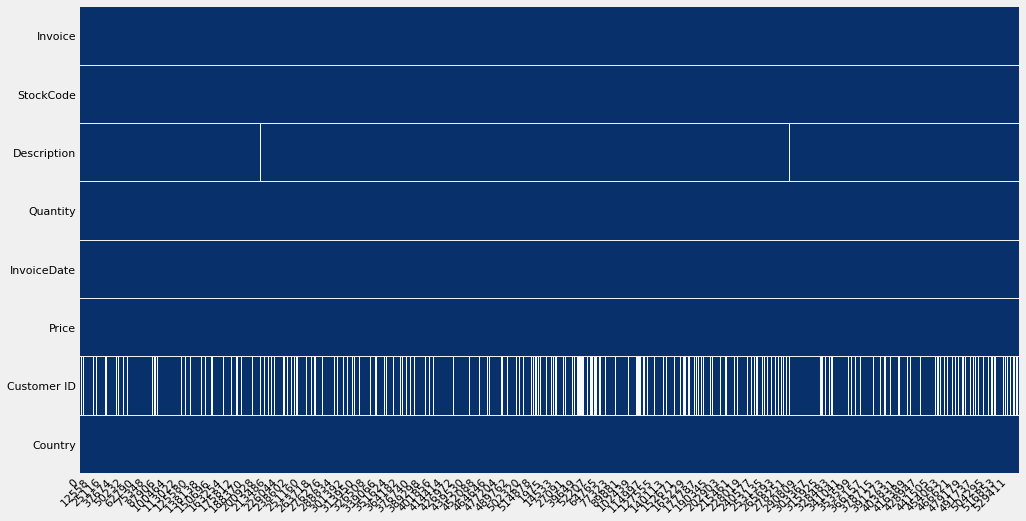

In [17]:
# Exploring the missing values in the dataset and their distribution using the plot_missing_value function from jcopml library

plot_missing_value(final_retail_data, return_df = True)

# Here, we can see the absolute number of missing values per variable and the proportion so we can decide how to handle the missing values
# Also visually presented, including the distribution.

In [18]:
# Exploring the descriptives of the numerical features 

final_retail_data.describe()

,Quantity,Price,Customer ID
count,1.067371e+06,1.067371e+06,824364.000000
mean,9.938898e+00,4.649388e+00,15324.638504
std,1.727058e+02,1.235531e+02,1697.464450
min,-8.099500e+04,-5.359436e+04,12346.000000
25%,1.000000e+00,1.250000e+00,13975.000000
50%,3.000000e+00,2.100000e+00,15255.000000
75%,1.000000e+01,4.150000e+00,16797.000000
max,8.099500e+04,3.897000e+04,18287.000000


In [19]:
# Exploring the outliers in the quantity variable

Q1_quan = final_retail_data['Quantity'].quantile(0.25)
Q3_quan = final_retail_data['Quantity'].quantile(0.75)

IQR_quan = Q3_quan - Q1_quan

LB_quan = float(Q1_quan) - (1.5 * IQR_quan)
UB_quan = float(Q3_quan) + (1.5 * IQR_quan)

print ('Q1 = {}'.format(Q1_quan))
print ('Q3 = {}'.format(Q3_quan))

print ('IQR = Q3 - Q1 = {}'.format(IQR_quan))
print ('lower bound = Q1 - 1.5 * IGR = {}'.format(LB_quan))
print ('upper bound = Q3 + 1.5 * IGR = {}'.format(UB_quan))

Q1 = 1.0
Q3 = 10.0
IQR = Q3 - Q1 = 9.0
lower bound = Q1 - 1.5 * IGR = -12.5
upper bound = Q3 + 1.5 * IGR = 23.5


In [21]:
# Exploring the outliers in the price  

Q1_price = final_retail_data['Price'].quantile(0.25)
Q3_price = final_retail_data['Price'].quantile(0.75)

IQR_price = Q3_price - Q1_price

LB_price = float(Q1_price) - (1.5 * IQR_price)
UB_price = float(Q3_price) + (1.5 * IQR_price)

print ('Q1 = {}'.format(Q1_price))
print ('Q3 = {}'.format(Q3_price))

print ('IQR = Q3 - Q1 = {}'.format(IQR_price))
print ('lower bound = Q1 - 1.5 * IQR = {}'.format(LB_price))
print ('upper bound = Q1 - 1.5 * IQR = {}'.format(UB_price))

Q1 = 1.25
Q3 = 4.15
IQR = Q3 - Q1 = 2.9000000000000004
lower bound = Q1 - 1.5 * IQR = -3.1000000000000005
upper bound = Q1 - 1.5 * IQR = 8.5


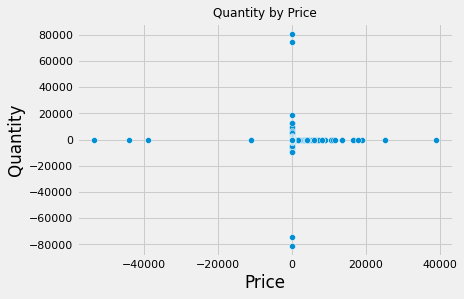

In [22]:
# Plotting Quantity by Price

sns.scatterplot(final_retail_data['Price'], final_retail_data['Quantity'])
plt.title('Quantity by Price', fontsize = 12);

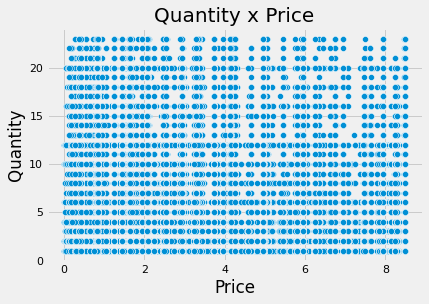

In [23]:
# Plotting the quantity by the price without the outliers

dx = final_retail_data[final_retail_data['Quantity'] > 0]
dy = final_retail_data[final_retail_data['Price'] > 0]

filtered_quantity = dx.query('(@Q1_quan - 1.5 * @IQR_quan) <= Quantity <= (@Q3_quan + 1.5 * @IQR_quan)')

filtered_price = dy.query('(@Q1_price - 1.5 * @IQR_price) <= Price <= (@Q3_price + 1.5 * @IQR_price)')

filtered_quantity = filtered_quantity.reset_index(drop=True)
filtered_price = filtered_price.reset_index(drop=True)

sns.scatterplot(filtered_price['Price'], filtered_quantity['Quantity'])
plt.title('Quantity x Price', fontsize = 20);

Text(0.5, 1.0, 'Quantity x Price')

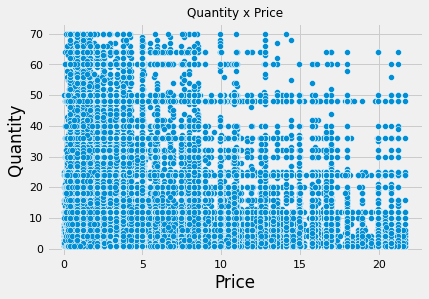

In [24]:
# Plotting the quantity by the price with an increased scope, considering some of the outliers
# 1st quantile at 0.5 and the third quantile at 0.95

Q1_quan_custom = final_retail_data['Quantity'].quantile(0.5)
Q3_quan_custom = final_retail_data['Quantity'].quantile(0.95)
IQR_quan_custom = Q3_quan_custom - Q1_quan_custom

Q1_price_custom = final_retail_data['Price'].quantile(0.5)
Q3_price_custom = final_retail_data['Price'].quantile(0.95)
IQR_price_custom = Q3_price_custom - Q1_price_custom

dx = final_retail_data[final_retail_data['Quantity'] > 0]
dy = final_retail_data[final_retail_data['Price'] > 0]

filtered_quantity = dx.query('(@Q1_quan_custom - 1.5 * @IQR_quan_custom) <= Quantity <= (@Q3_quan_custom + 1.5 * @IQR_quan_custom)')
filtered_price = dy.query('(@Q1_price_custom - 1.5 * @IQR_quan_custom) <= Price <= (@Q3_price_custom + 1.5 * @IQR_price_custom)')

filtered_quantity = filtered_quantity.reset_index(drop = True)
filtered_price = filtered_price.reset_index(drop = True)

sns.scatterplot(filtered_price['Price'], filtered_quantity['Quantity'])
plt.title('Quantity x Price', fontsize = 12)

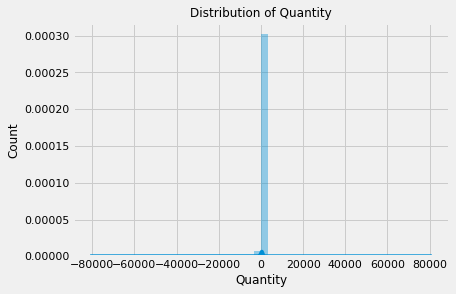

In [32]:
# Distribution of quantity 

sns.distplot(final_retail_data['Quantity'])
plt.title('Distribution of Quantity', fontsize = 12)
plt.xlabel('Quantity', fontsize = 12)
plt.ylabel('Count', fontsize = 12)
plt.show()

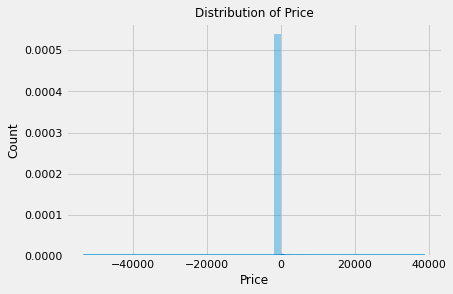

In [31]:
# Distribution of the price 

sns.distplot(final_retail_data['Price'])
plt.title('Distribution of Price', fontsize = 12)
plt.xlabel('Price', fontsize = 12)
plt.ylabel('Count', fontsize = 12)
plt.show()

Text(0, 0.5, 'Country Name')

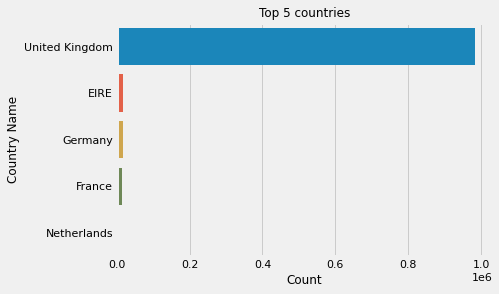

In [30]:
# Top 5[any number] of countries of customers 

x = final_retail_data['Country'].value_counts().head(5)
sns.barplot(x = x.values, y = x.index, )
plt.title('Top 5 countries', fontsize = 12)
plt.xlabel('Count', fontsize = 12)
plt.ylabel('Country Name', fontsize= 12)

In [33]:
# Listing out the distribution of customers by country 

x = final_retail_data['Country'].nunique()
print ('Total customer per country {}'.format(x))

country = pd.DataFrame(final_retail_data['Country'].value_counts()).reset_index()

country.columns = ['Country', 'Number of Customers']
country

Total customer per country 43


,Country,Number of Customers
0,United Kingdom,981330
1,EIRE,17866
2,Germany,17624
3,France,14330
4,Netherlands,5140
5,Spain,3811
6,Switzerland,3189
7,Belgium,3123
8,Portugal,2620
9,Australia,1913


In [34]:
# Dropping the observations with missing values 

final_retail_data = final_retail_data.dropna()

final_retail_data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [35]:
# Dimensions of the remaining observations without observations with missing values

final_retail_data.shape

(824364, 8)

In [36]:
# Checking the unique categories of the invoice variable

final_retail_data['Invoice'].unique().shape

# Inference, 44876 unique invoices in the whole dataset, which implies that the dataset focuses on the items purchased per individual
# A sampling can be done by invoice

(44876,)

In [37]:
# Exploring the unique customer, through the customer ID

final_retail_data['Customer ID'].unique().shape

# Inference, there are 5942 unique customers who have purchased various items 44876 times in total
# A sampling can done by customer as well

(5942,)

In [38]:
# Exploring the unique invoices that have had the associated payments made 

final_retail_data['InvoiceDate'].unique().shape

# Inference, overall, 41439 of 44876 invoices have been paid. 
# Leaving 3437 invoices yet to be paid

(41439,)

In [39]:
# Checking the unique identifier for the items purchased

final_retail_data['StockCode'].unique().shape

# Inference, overall, there are about 4646 unique items that have been purchased by the customers 

(4646,)

In [40]:
# checking the distribution of the date variable

final_retail_data.InvoiceDate.describe(datetime_is_numeric=True)

# Inference, overall, the dataset is distributed between 1st December 2009 and 9th December 2011

count                           824364
mean     2011-01-01 22:29:28.041644288
min                2009-12-01 07:45:00
25%                2010-07-06 11:58:00
50%                2010-12-03 14:26:00
75%                2011-07-27 15:14:00
max                2011-12-09 12:50:00
Name: InvoiceDate, dtype: object

In [41]:
# Sorting the dataset by quantity to see the observations with the highest quantity

final_retail_data.sort_values('Quantity', ascending=False).head() 

# You can switch out the head with "tail" to see the observations with the lowest quantity or even negative quantities. 
# In the brackets, you can input numbers to choose how many observations to be displayed

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom
90857,497946,37410,BLACK AND WHITE PAISLEY FLOWER MUG,19152,2010-02-15 11:57:00,0.10,13902.0,Denmark
127168,501534,21091,SET/6 WOODLAND PAPER PLATES,12960,2010-03-17 13:09:00,0.10,13902.0,Denmark
127166,501534,21099,SET/6 STRAWBERRY PAPER CUPS,12960,2010-03-17 13:09:00,0.10,13902.0,Denmark


In [42]:
# Sorting the dataset by quantity to see the observations with the lowest (negative) quantity

final_retail_data.sort_values('Quantity', ascending=False).tail() 

# In the brackets, you can input numbers to choose how many observations to be displayed

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
359669,C524235,21088,SET/6 FRUIT SALAD PAPER CUPS,-7128,2010-09-28 11:02:00,0.08,14277.0,France
4268,C536757,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,-9360,2010-12-02 14:23:00,0.03,15838.0,United Kingdom
507225,C536757,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,-9360,2010-12-02 14:23:00,0.03,15838.0,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346.0,United Kingdom
540422,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,2011-12-09 09:27:00,2.08,16446.0,United Kingdom


In [43]:
# Filtering out the obserrvations with negative quantities and exploring the dimensions

final_retail_data[final_retail_data['Quantity'] < 0].shape

# Inference, overall, there are 18744 observations with negative items purchased. 
# This could implies item returns

(18744, 8)

In [44]:
# Mapping the transactions with negative quantities to a dataframe

negative_quantity = final_retail_data[final_retail_data['Quantity'] < 0]

negative_quantity

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321.0,Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321.0,Australia
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321.0,Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315.0,United Kingdom


In [45]:
# Sorting the dataset by price to see the observations with the highest price

final_retail_data.sort_values('Price', ascending=False).head(10) 

# Interesting observation, some items seems to be purchased and returned. Seems to be the case for several items/transactions. 

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
222681,C556445,M,Manual,-1,2011-06-10 15:31:00,38970.00,15098.0,United Kingdom
241824,C512770,M,Manual,-1,2010-06-17 16:52:00,25111.09,17399.0,United Kingdom
135013,502263,M,Manual,1,2010-03-23 15:22:00,10953.50,12918.0,United Kingdom
135014,C502264,M,Manual,-1,2010-03-23 15:24:00,10953.50,12918.0,United Kingdom
135012,C502262,M,Manual,-1,2010-03-23 15:20:00,10953.50,12918.0,United Kingdom
372833,C525398,M,Manual,-1,2010-10-05 11:47:00,10468.80,14063.0,United Kingdom
358639,524159,M,Manual,1,2010-09-27 16:12:00,10468.80,14063.0,United Kingdom
342135,C522793,M,Manual,-1,2010-09-16 14:53:00,10468.80,14063.0,United Kingdom
74357,C496116,M,Manual,-1,2010-01-29 11:05:00,8985.60,17949.0,United Kingdom
74356,496115,M,Manual,1,2010-01-29 11:04:00,8985.60,17949.0,United Kingdom


In [46]:
# Sorting the dataset by price to see the observations with the highest price

final_retail_data.sort_values('Price', ascending=False).tail(10) 

# Several items with zero price and quantity specified, perhaps the case of a discount

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
392008,527084,22630,DOLLY GIRL LUNCH BOX,64,2010-10-14 15:33:00,0.0,14646.0,Netherlands
33576,539263,22580,ADVENT CALENDAR GINGHAM SACK,4,2010-12-16 14:36:00,0.0,16560.0,United Kingdom
471776,533822,22845,VINTAGE CREAM CAT FOOD CONTAINER,1,2010-11-19 09:40:00,0.0,12647.0,Germany
89180,497843,TEST001,This is a test product.,5,2010-02-12 15:47:00,0.0,14827.0,United Kingdom
314748,564651,21786,POLKADOT RAIN HAT,144,2011-08-26 14:19:00,0.0,14646.0,Netherlands
439309,531361,21843,RED RETROSPOT CAKE STAND,2,2010-11-07 14:26:00,0.0,12820.0,United Kingdom
166143,505083,22376,AIRLINE BAG VINTAGE JET SET WHITE,1,2010-04-20 09:56:00,0.0,12623.0,Germany
420404,572893,21208,PASTEL COLOUR HONEYCOMB FAN,5,2011-10-26 14:36:00,0.0,18059.0,United Kingdom
479079,577129,22464,HANGING METAL HEART LANTERN,4,2011-11-17 19:52:00,0.0,15602.0,United Kingdom
436961,574252,M,Manual,1,2011-11-03 13:24:00,0.0,12437.0,France


In [47]:
# Filtering out the obserrvations with negative quantities and exploring the dimensions

final_retail_data[final_retail_data['Price'] == 0].shape

# Inference, there are no items with the Price less than 0. (switch the operator)
# Although there are 71 transactions with Price = 0

(71, 8)

In [48]:
# Mapping the transactions for which the price was 0 to a dataframe

zero_price_paid = final_retail_data[final_retail_data['Price'] == 0]

zero_price_paid

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
4674,489825,22076,6 RIBBONS EMPIRE,12,2009-12-02 13:34:00,0.0,16126.0,United Kingdom
6781,489998,48185,DOOR MAT FAIRY CAKE,2,2009-12-03 11:19:00,0.0,15658.0,United Kingdom
16107,490727,M,Manual,1,2009-12-07 16:38:00,0.0,17231.0,United Kingdom
18738,490961,22065,CHRISTMAS PUDDING TRINKET POT,1,2009-12-08 15:25:00,0.0,14108.0,United Kingdom
18739,490961,22142,CHRISTMAS CRAFT WHITE FAIRY,12,2009-12-08 15:25:00,0.0,14108.0,United Kingdom
...,...,...,...,...,...,...,...,...
479079,577129,22464,HANGING METAL HEART LANTERN,4,2011-11-17 19:52:00,0.0,15602.0,United Kingdom
479553,577168,M,Manual,1,2011-11-18 10:42:00,0.0,12603.0,Germany
480649,577314,23407,SET OF 2 TRAYS HOME SWEET HOME,2,2011-11-18 13:23:00,0.0,12444.0,Norway
485985,577696,M,Manual,1,2011-11-21 11:57:00,0.0,16406.0,United Kingdom


In [49]:
# Removing transactions with negative quantities (returned items)

qclean_final_retail_data = final_retail_data[final_retail_data['Quantity'] >= 0]

clean_final_retail_data = qclean_final_retail_data[qclean_final_retail_data['Price'] > 0]

clean_final_retail_data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [50]:
clean_final_retail_data.shape

(805549, 8)

In [51]:
# Grouping the invoices by the Invoice Date and aggregating the item quantity and price

grouped_invoice_date = clean_final_retail_data.groupby('InvoiceDate').agg({'Quantity': np.sum, 'Price': np.sum})

grouped_invoice_date

,Quantity,Price
InvoiceDate,,
2009-12-01 07:45:00,166,32.65
2009-12-01 07:46:00,60,10.50
2009-12-01 09:06:00,193,70.88
2009-12-01 09:08:00,145,83.45
2009-12-01 09:24:00,826,44.05
...,...,...
2011-12-09 12:23:00,76,3.30
2011-12-09 12:25:00,120,2.57
2011-12-09 12:31:00,278,37.78


In [53]:
# Checking the descriptive statistics for the aggregated quantity and price based on the grouped invoice date

grouped_invoice_date.describe()

,Quantity,Price
count,34585.000000,34585.000000
mean,309.560995,74.686783
std,1279.329827,164.928220
min,1.000000,0.060000
25%,78.000000,21.100000
50%,165.000000,49.610000
75%,312.000000,93.060000
max,87167.000000,10953.500000


In [54]:
# First ensure the InvoiceDate variable is of the datetime data type

grouped_invoice_date.index = pd.to_datetime(grouped_invoice_date.index)

# Extract the date alone (without the time part) into a new colum

grouped_invoice_date['Date'] = grouped_invoice_date.index.date

grouped_invoice_date

,Quantity,Price,Date
InvoiceDate,,,
2009-12-01 07:45:00,166,32.65,2009-12-01
2009-12-01 07:46:00,60,10.50,2009-12-01
2009-12-01 09:06:00,193,70.88,2009-12-01
2009-12-01 09:08:00,145,83.45,2009-12-01
2009-12-01 09:24:00,826,44.05,2009-12-01
...,...,...,...
2011-12-09 12:23:00,76,3.30,2011-12-09
2011-12-09 12:25:00,120,2.57,2011-12-09
2011-12-09 12:31:00,278,37.78,2011-12-09


In [55]:
# Grouping the Transactions by invoice into total transaction by date through the aggregation of the Quantity and the Price paid

total_daily_transaction = grouped_invoice_date.groupby('Date').agg({'Quantity':np.sum, 'Price': np.sum})

total_daily_transaction

,Quantity,Price
Date,,
2009-12-01,24437,7070.14
2009-12-02,29771,6857.51
2009-12-03,48031,7069.25
2009-12-04,20069,5408.13
2009-12-05,5119,1443.26
...,...,...
2011-12-05,38428,10688.02
2011-12-06,27827,6104.18
2011-12-07,41102,5549.63


In [56]:
# Exploring the descriptives of the total daily transactions

total_daily_transaction.describe()

,Quantity,Price
count,604.000000,604.000000
mean,17725.442053,4276.560262
std,12056.168495,2314.650160
min,2048.000000,633.090000
25%,11026.000000,2876.355000
50%,14998.500000,3701.775000
75%,21259.000000,5097.827500
max,124766.000000,20885.710000


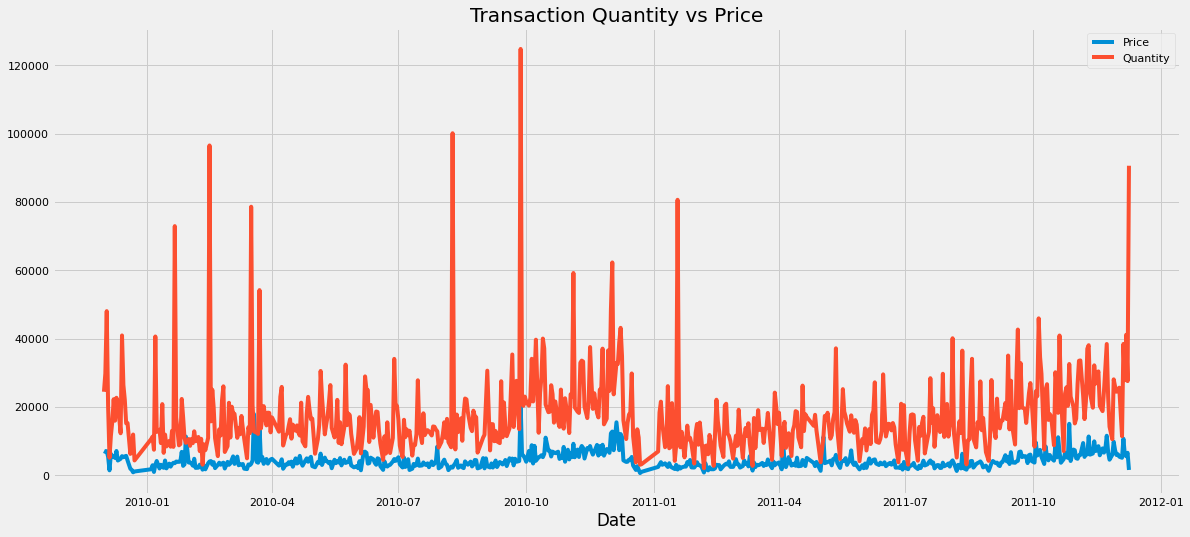

In [57]:
# Plotting the actual daily transaction prices and the quantities

total_daily_transaction.Price.plot(figsize = (18,8), title = "Transaction Price")
total_daily_transaction.Quantity.plot(figsize = (18, 8), title = "Transaction Quantity")
plt.title("Transaction Quantity vs Price")
plt.legend()
plt.show()

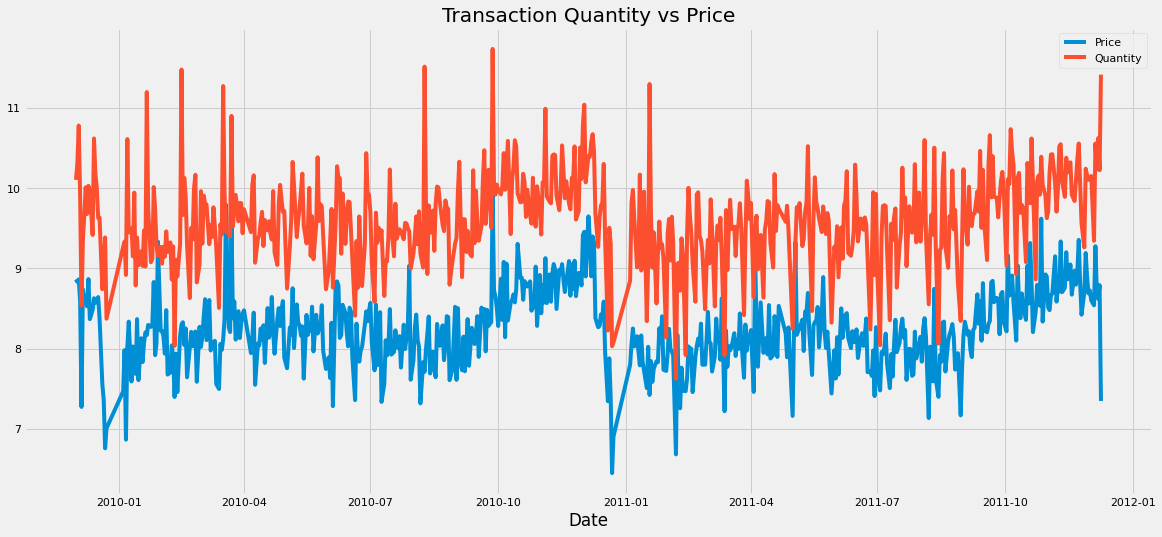

In [58]:
# Plotting the log of the daily transaction prices and the quantities

np.log(total_daily_transaction.Price).plot(figsize = (18,8), title = "Transaction Price")
np.log(total_daily_transaction.Quantity).plot(figsize = (18, 8), title = "Transaction Quantity")
plt.title("Transaction Quantity vs Price")
plt.legend()
plt.show()

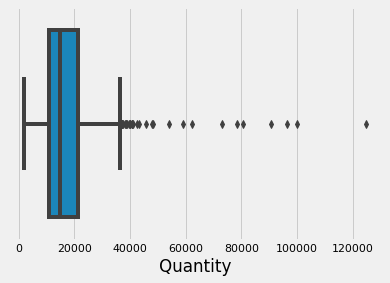

In [59]:
# Checking for outliers in the daily sales quantity

sns.boxplot(total_daily_transaction.Quantity)
sns.set_palette("cubehelix", 3)
plt.show()

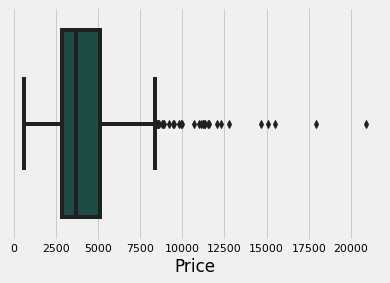

In [60]:
# Checking for outliers in the daily transaction price

sns.boxplot(total_daily_transaction.Price)
sns.set_palette("cubehelix", 3)
plt.show()

In [61]:
# Grouping the transactions by the unique customer ID, and summing up the quantity and the price

grouped_customer = clean_final_retail_data.groupby('Customer ID').agg({'Quantity': np.sum, 'Price': np.sum})

grouped_customer

,Quantity,Price
Customer ID,,
12346.0,74285,207.40
12347.0,3286,644.16
12348.0,2714,193.10
12349.0,1624,1480.44
12350.0,197,65.30
...,...,...
18283.0,1733,1719.75
18284.0,494,91.09
18285.0,145,100.20


In [62]:
# Exploring the descriptive statistics of the quantity and price by unique customer

grouped_customer.describe()

,Quantity,Price
count,5878.000000,5878.000000
mean,1821.396223,439.442395
std,8963.011855,1341.938515
min,1.000000,0.170000
25%,190.000000,65.285000
50%,491.500000,168.575000
75%,1376.000000,442.737500
max,367193.000000,57753.060000


In [63]:
# Grouping the dataset by invoice and aggregating the price per invoice, essentially invoice value

grouped_invoice_df = clean_final_retail_data.groupby('Invoice')['Price'].sum().reset_index(name='InvoiceValue')

grouped_invoice_df

,Invoice,InvoiceValue
0,489434,32.65
1,489435,10.50
2,489436,70.88
3,489437,83.45
4,489438,44.05
...,...,...
36964,581583,3.30
36965,581584,2.57
36966,581585,37.78
36967,581586,20.23


In [64]:
# Grouping the dataset by the invoicedate and aggregating the invoice value

grouped_invoice_date_df = clean_final_retail_data.groupby('InvoiceDate')['Price'].sum().reset_index(name='InvoiceValue')

grouped_invoice_date_df

,InvoiceDate,InvoiceValue
0,2009-12-01 07:45:00,32.65
1,2009-12-01 07:46:00,10.50
2,2009-12-01 09:06:00,70.88
3,2009-12-01 09:08:00,83.45
4,2009-12-01 09:24:00,44.05
...,...,...
34580,2011-12-09 12:23:00,3.30
34581,2011-12-09 12:25:00,2.57
34582,2011-12-09 12:31:00,37.78
34583,2011-12-09 12:49:00,20.23


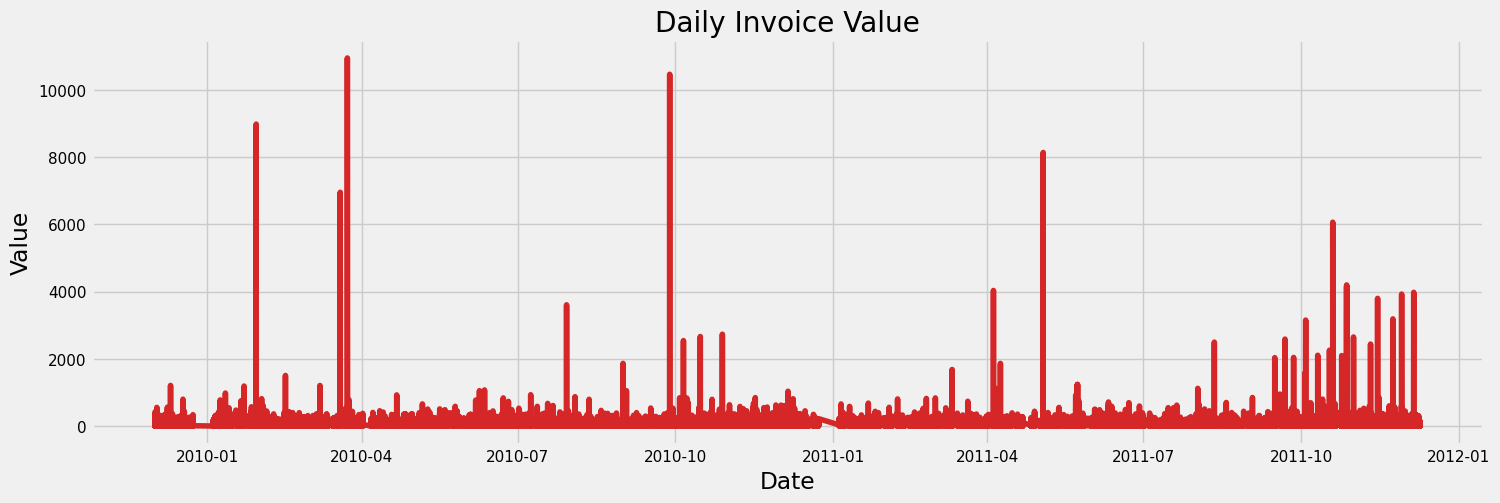

In [65]:
# Plotting the daily total invoice value for all transactions

def plot_df(df, x, y, title = "", xlabel = "Date", ylabel = "Value", dpi = 100):
  plt.figure(figsize = (16, 5), dpi=dpi)
  plt.plot(x, y, color = "tab:red")
  plt.gca().set(title = title, xlabel = xlabel, ylabel = ylabel)
  plt.show()

plot_df(grouped_invoice_date_df, x = grouped_invoice_date_df.InvoiceDate, y = grouped_invoice_date_df.InvoiceValue, title = "Daily Invoice Value")

In [66]:
# Exploring the number of days between the earliest entry and the last entry for the transactions

grouped_invoice_date_df['InvoiceDate'].max() - grouped_invoice_date_df['InvoiceDate'].min()

Timedelta('738 days 05:05:00')

In [68]:
# Extracting the invoice month from the grouped invoice dataset

grouped_invoice_date_df['month'] = grouped_invoice_date_df['InvoiceDate'].dt.month

grouped_invoice_date_df.head()


## - Possible further action (PFA) 
# Extract year and month, group observations in the full dataset by year and month, 
# Same can be done for the quarter as well. 
# Explore variations and nuances within and between the various cycles 

,InvoiceDate,InvoiceValue,month
0,2009-12-01 07:45:00,32.65,12
1,2009-12-01 07:46:00,10.50,12
2,2009-12-01 09:06:00,70.88,12
3,2009-12-01 09:08:00,83.45,12
4,2009-12-01 09:24:00,44.05,12


In [ ]:
# Datasets extracted from the overall database

# Merged dataset from the two dataframes from the spreadsheets
final_retail_data

# Cleaned final retail dataset, excluding negative quantity transactions (returned merchandise) and transactions for which no price was paid (discounts/bonanza/stolen)
clean_final_retail_data

# Total retail transactions grouped by the day
total_daily_transaction

# Transaction with negative (returned) quantities 
negative_quantity

# Transactions with zero prices
zero_price_paid

# Transactions grouped by the invoice dates, essentially the date payments are made 
grouped_invoice_date_df

# Transactions grouped by the invoices raise, differentiated from invoice date, interpreted to be date when payments are made 
grouped_invoice_df

# Transactions grouped by customers. 
grouped_customer

##### There will be more

In [ ]:
from google.colab import drive # for more on writing and reading files through colab https://towardsdatascience.com/reading-and-writing-files-with-google-colaboratory-f0c234683946
drive.mount("/drive")

Mounted at /drive


In [ ]:
# Exporting the data to a csv file 

clean_final_retail_data.to_csv("/drive/My Drive/Colab Notebooks/clean_final_retail_data.csv", index = False)